## Reccurent Neural Network and Language modeling

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sayankotor/BERT_botcamp19/blob/master/simple_classification_problem.ipynb)

### 0 step. 
### Why LSTM, not RNN ?

<img src='https://memeworld.funnyjunk.com/pictures/The+tragedy+of+a+three+second+memory_b414ea_4853499.jpg' width=480px>

We need "long" memory.

 __He__ doesn't have very much confidents in __himself__.
 
 __She__ doesn't have very much confidents in __herself__.

<img src='https://drive.google.com/uc?export=view&id=1eqfPpRMsK6lJemwZtqVJW8hKFqT7bckv' width=680px>

* The hidden state in RNN:
    $h_t = tanh(h_{t-1}W_h + x_t W_x)$

* Gradient (state derivative by weights):

$$\frac{\partial{h_t}}{\partial W_h} = \sum_{k =0 ..t}\frac{\partial{h_t}}{\partial {h_k}}\cdot\frac{\partial{h_k}}{\partial {W_k}}$$
    
$$\frac{\partial{h_t}}{\partial {h_k}}=\prod_{i=k+1..t}\frac{\partial{h_i}}{\partial {h_{i-1}}} \approx W_h^{t - k}$$

* if norm($W_h$) > 1 -> gradient explodes
* if norm($W_h$) < 1 -> gradient vanishes ("three second memory")

* LSTM stores "memory state". On each step several units in "memory state" is decided to forget, several information is decided to be added to "memory state".

<img src='https://i.stack.imgur.com/aTDpS.png' width=680px>

## Dataset

_data by neelshah18 from [here](https://www.kaggle.com/neelshah18/arxivdataset/)_

There is a title's and abstracts of ML-articles from 1992 to 2014


In [3]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XcwXj1HOr87Mrkmm1s0KQkyhd6rvXSp9' -O arxivData.json

--2019-10-22 09:44:28--  https://docs.google.com/uc?export=download&id=1XcwXj1HOr87Mrkmm1s0KQkyhd6rvXSp9
Resolving docs.google.com (docs.google.com)... 64.233.184.113, 64.233.184.138, 64.233.184.139, ...
Connecting to docs.google.com (docs.google.com)|64.233.184.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lt5sgfvre66cesvsg6mlvsv1jkhjitbk/1571731200000/01961971800886548445/*/1XcwXj1HOr87Mrkmm1s0KQkyhd6rvXSp9?e=download [following]
--2019-10-22 09:44:31--  https://doc-00-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lt5sgfvre66cesvsg6mlvsv1jkhjitbk/1571731200000/01961971800886548445/*/1XcwXj1HOr87Mrkmm1s0KQkyhd6rvXSp9?e=download
Resolving doc-00-6s-docs.googleusercontent.com (doc-00-6s-docs.googleusercontent.com)... 64.233.167.132, 2a00:1450:400c:c0a::84
Connecting to doc-00-6s-docs.googleusercontent.com (doc-00-6s-d

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#!tar -xvzf arxivData.json.tar.gz
data = pd.read_json("./arxivData.json")

In [6]:
data.head()

,author,day,id,link,month,summary,tag,title,year
0,"[{'name': 'Ahmed Osman'}, {'name': 'Wojciech S...",1,1802.00209v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,We propose an architecture for VQA which utili...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Dual Recurrent Attention Units for Visual Ques...,2018
1,"[{'name': 'Ji Young Lee'}, {'name': 'Franck De...",12,1603.03827v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,Recent approaches based on artificial neural n...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Sequential Short-Text Classification with Recu...,2016
2,"[{'name': 'Iulian Vlad Serban'}, {'name': 'Tim...",2,1606.00776v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,We introduce the multiresolution recurrent neu...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Multiresolution Recurrent Neural Networks: An ...,2016
3,"[{'name': 'Sebastian Ruder'}, {'name': 'Joachi...",23,1705.08142v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",5,Multi-task learning is motivated by the observ...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Learning what to share between loosely related...,2017
4,"[{'name': 'Iulian V. Serban'}, {'name': 'Chinn...",7,1709.02349v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",9,We present MILABOT: a deep reinforcement learn...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",A Deep Reinforcement Learning Chatbot,2017


In [7]:
print (data['summary'].values[:5])

['We propose an architecture for VQA which utilizes recurrent layers to\ngenerate visual and textual attention. The memory characteristic of the\nproposed recurrent attention units offers a rich joint embedding of visual and\ntextual features and enables the model to reason relations between several\nparts of the image and question. Our single model outperforms the first place\nwinner on the VQA 1.0 dataset, performs within margin to the current\nstate-of-the-art ensemble model. We also experiment with replacing attention\nmechanisms in other state-of-the-art models with our implementation and show\nincreased accuracy. In both cases, our recurrent attention mechanism improves\nperformance in tasks requiring sequential or relational reasoning on the VQA\ndataset.'
 'Recent approaches based on artificial neural networks (ANNs) have shown\npromising results for short-text classification. However, many short texts\noccur in sequences (e.g., sentences in a document or utterances in a dialog

**Preprocessing**

Let see to data. We have __author__, __day__, __link__, ect. fields. 

To our purpose we need only texts, so we will extract ['title'] and ['summary'] column.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.

In [0]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

While we put sequence(sentence, text) to RNN, we can assume char, or token, or word as a sequence unit. 

We should enumerate all possible unit and build a vocabulary on this set.

The __char-level__ language modelling is more preferable because the problem of missing words (out-of-vocabulary words) is removed.

* Our next step is __building char-level vocabulary__. 
  Put simply, you need to assemble a list of all unique tokens in the dataset.

In [9]:
# get all unique characters from lines (including capital letters and symbols)
d = {}
tokens = []

for line in lines:
    for token in list(line):
        if token not in d: 
            d[token] = 1
            tokens.append(token)
        else: d[token] += 1

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens


n_tokens =  136


In [0]:
token_to_id = {}
for ind, elem in enumerate(tokens):
    token_to_id[elem] = ind

In [11]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


* Now we need function to assemble several strings in a integet matrix `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [0]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype='int32'):
    """Casts a list of lines into tf-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

Let test it

In [13]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))


[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


## 1st step. 
## Custom LSTM-cell
Now we will create simple 1-LSTM-cell on Tensorflow

In [0]:
import tensorflow as tf

tf.reset_default_graph()

In [0]:
emb_size = 256
cell_size = 512
batch_size = 5
max_len = 500
voc_size = n_tokens

Create *dict* of expected network parts

In [0]:

network_dict = {}

**Placeholders and nodes in Tensorflow**

Graph in Tensorflaw is a recipe of calculation some math expression.
Placeholders are related to variables, nodes - to function.

I.e. in __a+b__ - __a__ and __b__ are placeholders, __+__ - node. 

_Disclaimer: This is a very free description. If you are a level 80 tensorflaw master, ignore this cell.

### Creating placeholder's for input data
Placeholders are cells into which input data will be transmitted.
In our case, only word indices are input. We will create the necessary placeholders for our network.

In [0]:
network_dict['input_ix'] = tf.placeholder(shape=(batch_size, max_len), 
                                          dtype=tf.int32, 
                                          name="text_input") # bs, max_len


Creating Vector Representation of words.

While we work with words, we want to translate indexes of words into the a vectors of fixed dimension. Such vectors are called __vector representations of words__ (__word embeddings__).
Create a matrix of vector representations of size (*dictionary size*, *size of vector representations*) and create a node in the computational graph that will "turn" the input word indices into vector representations.

In [43]:
var_embs = tf.get_variable('var_embs', shape=[voc_size, emb_size], dtype=tf.float32, initializer=tf.random_uniform_initializer(-1, 1), trainable=True)
    
    
network_dict['word_embeddings'] = tf.nn.embedding_lookup(var_embs, network_dict['input_ix'])


print ("Input batch shape", network_dict['input_ix'].shape)
print("Shape of `word_embeddings` tensor:", network_dict['word_embeddings'].shape)


Input batch shape (5, 500)
Shape of `word_embeddings` tensor: (5, 500, 256)


Now we need variables for weights and bias of candiadate gate, input gate, output gate, forget gate.

In [0]:
network_dict['W_i'] = tf.get_variable('W_i',shape=[emb_size + cell_size, cell_size],dtype=tf.float32, initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))

network_dict['b_i'] = tf.get_variable('b_i', shape=[cell_size,], dtype=tf.float32, initializer=tf.zeros_initializer())

# Forget weights + bias
network_dict['W_f'] = tf.get_variable('W_f', shape=[emb_size + cell_size, cell_size], dtype=tf.float32, initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))

network_dict['b_f'] = tf.get_variable('b_f', shape=[cell_size,], dtype=tf.float32, initializer=tf.zeros_initializer())
    
# Memory weights + bias
network_dict['W_c'] = tf.get_variable('W_c', shape=[emb_size + cell_size, cell_size], dtype=tf.float32, initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))

network_dict['b_c'] = tf.get_variable('b_c', shape=[cell_size, ], dtype=tf.float32, initializer=tf.zeros_initializer())
    
# Output weights + bias
network_dict['W_o'] = tf.get_variable('W_o', shape=[emb_size + cell_size, cell_size], dtype=tf.float32, initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
    
network_dict['b_o'] = tf.get_variable('b_o', shape=[cell_size,], dtype=tf.float32,initializer=tf.zeros_initializer())

Apply activation as per formula in picture above for LSTM cell

In [0]:
def lstm_cell(word_embeddings, # (bs, embedding_size)
              h_t_1, # (bs, hidden_size)
              c_t_1, # (bs, hidden_size)
              network_dict): # (bs, hidden_size)
    W_i = network_dict['W_i']
    b_i = network_dict['b_i']
    W_o = network_dict['W_o']
    b_o = network_dict['b_o']
    W_f = network_dict['W_f']
    b_f = network_dict['b_f']
    W_c = network_dict['W_c']
    b_c = network_dict['b_c']
    concated_input = tf.concat([word_embeddings, h_t_1], axis=1) # (bs, hidden_size + embedding_size)
    forget_gate = tf.nn.sigmoid(tf.matmul(concated_input, W_f) + b_f) # (bs, hidden_size)
    input_gate = tf.nn.sigmoid(tf.matmul(concated_input, W_i) + b_i) # (bs, hidden_size)
    update = tf.nn.tanh(tf.matmul(concated_input, W_c) + b_c) # (bs, hidden_size)
    output_gate = tf.nn.sigmoid(tf.matmul(concated_input, W_o) + b_o) # (bs, hidden_size)
    c_t = c_t_1 * forget_gate + (update * input_gate) # (bs, hidden_size)
    h_t = tf.nn.tanh(c_t) * output_gate # (bs, hidden_size)
    return h_t, c_t # (bs, hidden_size), (bs, hidden_size)

Define LSTM output

In [0]:
def create_lstm(network_dict):
    word_embeddings = network_dict['word_embeddings'] # (batch_size, max_len, embedding_size)
    outputs = []
    # create special constant for first timestep cell state
    zero_state = tf.zeros(shape=(batch_size, cell_size))
    c_t = zero_state
    h_t = zero_state
    # iterate over each word
    for timestep in range(max_len):
        # get a slice for t-th word of each batch
        one_word_batch = word_embeddings[:, timestep, :]  # (batch_size, embedding_size)
        # compute lstm_cell
        h_t, c_t = lstm_cell(one_word_batch, h_t, c_t, network_dict)
        # remember the output for each step
        outputs.append(h_t)
    network_dict['lstm_outputs'] = outputs # list of size `max_len` of tensors (bs, hidden_size)
    
create_lstm(network_dict)

In [35]:
lstm_outputs = network_dict['lstm_outputs']
print("len(lstm_outputs): ", len(lstm_outputs))
print("stm_outputs[0].shape: ", lstm_outputs[0].shape)

len(lstm_outputs):  500
stm_outputs[0].shape:  (5, 512)


In [36]:
lstm_outputs = network_dict['lstm_outputs'] # list of size `max_len` of tensors (bs, hidden_size)
input_words_inds = network_dict['input_ix'] # (batch_size, max_example_len)

input_words = input_words_inds[:, 1:] # shift all input words left by 1
# and add <pad> token index (1) at the end each example
ones_vector = tf.ones(shape=[batch_size,1], dtype=tf.int32)
print (input_words.shape)
print (ones_vector.shape)
target_words =  tf.concat([input_words, ones_vector], axis = 1) # (bs, max_len)

print (target_words.shape)
W = tf.get_variable('W_softmax', # softmax layer weights
                  shape=[cell_size, voc_size], 
                  dtype=tf.float32,
                  initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
b = tf.get_variable('b_softmax', # softmax layer bias
                    shape=[voc_size,], 
                    dtype=tf.float32,
                    initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))

loss = tf.constant(0.0, dtype=tf.float32)

(5, 499)
(5, 1)
(5, 500)


In [37]:
print (W.shape, b.shape)

(512, 136) (136,)


In tensorflow, calculating softmax and cross-entropy is combined in one operation. In our case, it is __tf.nn.sparse_softmax_cross_entropy_with_logits__, which receives __logits__ - the size tensor (__batch size__, __dictionary size__) and __targets__ — an integer size tensor (__batch size__,) containing word indices. 

This operation returns the cross entropy for each example in the batch, so for the final loss function we take the average of all the losses in the batch.

In [47]:
def create_loss_function(network_dict):
    lstm_outputs = network_dict['lstm_outputs'] # list of size `max_len` of tensors (bs, hidden_size)
    input_words_inds = network_dict['input_ix'] # (batch_size, max_example_len)
    target_words = input_words_inds
    print (target_words.shape)
    W = tf.get_variable('W_softmax', # softmax layer weights
                      shape=[cell_size, voc_size], 
                      dtype=tf.float32,
                      initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
    b = tf.get_variable('b_softmax', # softmax layer bias
                        shape=[voc_size,], 
                        dtype=tf.float32,
                        initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
    
    loss = tf.constant(0.0, dtype=tf.float32)
    for t in range(max_len):
        logits = tf.matmul(lstm_outputs[t], W) + b # (bs, voc_size)
        softmax_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
                                                                      labels=target_words[:, t]) # (bs,)
        loss_t = tf.reduce_mean(softmax_loss) # batch_size, max_example_len
        loss += loss_t
    network_dict['loss'] = loss 

create_loss_function(network_dict)

Tensor("strided_slice_500:0", shape=(5, 499), dtype=int32)
(5, 500)


In [0]:
lr = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(network_dict['loss'])

Let see to the computational graph

In [0]:
def describe_graph():
    print("Trainable variables:")
    for var in tf.trainable_variables():
        print(var.name, ':',  var.shape)
    print()
    total_parameters = np.sum([np.prod(var.shape.as_list()) for var in tf.trainable_variables()])
    print("Total parameter count:", total_parameters)

In [22]:
describe_graph()

Trainable variables:
var_embs:0 : (136, 256)
W_i:0 : (768, 512)
b_i:0 : (512,)
W_f:0 : (768, 512)
b_f:0 : (512,)
W_c:0 : (768, 512)
b_c:0 : (512,)
W_o:0 : (768, 512)
b_o:0 : (512,)
W_softmax:0 : (512, 136)
b_softmax:0 : (136,)

Total parameter count: 1679496


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())


In [51]:
from random import sample
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

len(sample(train_lines, batch_size))

5

In [52]:
from IPython.display import clear_output
from random import sample
from tqdm import trange, tnrange

from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)
train_history = []


for i in trange(len(train_history), 10):
    batch = to_matrix(sample(train_lines, batch_size), max_len = max_len)
    loss_i, _ = sess.run([network_dict['loss'], train_step], {network_dict['input_ix']: batch})
    print (loss_i)

 10%|█         | 1/10 [01:04<09:39, 64.36s/it]

2459.0396


 20%|██        | 2/10 [01:04<06:01, 45.24s/it]

2127.5771


 30%|███       | 3/10 [01:05<03:42, 31.85s/it]

1798.2953


 40%|████      | 4/10 [01:06<02:14, 22.48s/it]

1453.0348


 50%|█████     | 5/10 [01:06<01:19, 15.92s/it]

1198.3193


 60%|██████    | 6/10 [01:07<00:45, 11.32s/it]

991.42334


 70%|███████   | 7/10 [01:08<00:24,  8.11s/it]

798.1683


 80%|████████  | 8/10 [01:08<00:11,  5.86s/it]

673.12634


 90%|█████████ | 9/10 [01:09<00:04,  4.29s/it]

551.0508


100%|██████████| 10/10 [01:09<00:00,  3.19s/it]

423.4505


Something move (loss decreasing)
You can output and see how input, output, forget parameters change while training.

To solve real problem the build-in cell are usialy used.

## Note
For development quality and model training speed, it is recommended to use the built-in tensorflow functions to create recurrent networks.

Functions for creating LSTM cells:
- `tf.contrib.rnn.BasicLSTMCell` - LSTM cell implementation
- `tf.contrib.rnn.GRUCell` - implementation of a GRU cell (contains fewer parameters than LSTM), may be more preferable to little task (i.e LM in short corpus), while LSTM works better on large-scale task.


Функции "развёртывания" рекурентных сетей
- `tf.nn.static_rnn` - function for "deploying" LSTM networks for fixed-length sequences
- `tf.nn.dynamic_rnn` - function for "deploying" the LSTM network for variable-length sequences (it is recommended to use this option in the documentation, which provides more flexible options
- `tf.contrib.seq2seq.sequence_loss` - function to apply the loss function to each output of the LSTM network


## 2nd step.
## Generate scientific abstract

This part based on YSDA NLP course https://github.com/yandexdataschool/nlp_course/blob/2019/week03_lm/homework.ipynb 

We shall train our language model on a corpora of [ArXiv](http://arxiv.org/) articles and see if we can generate a new one!

![img](https://media.npr.org/assets/img/2013/12/10/istock-18586699-monkey-computer_brick-16e5064d3378a14e0e4c2da08857efe03c04695e-s800-c85.jpg)

_Disclaimer: this has nothing to do with actual science. But it's fun, so who cares?!_

### RNN Language Models

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>


In [41]:
import tensorflow as tf
import keras, keras.layers as L
from keras.models import Model
tf.reset_default_graph()
sess = tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [0]:
class RNNLanguageModel:
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=512):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        """
        
        # YOUR CODE - create layers/variables/etc         
        self.emb = L.Embedding(n_tokens, emb_size)
        
        self.gru = L.LSTM(hid_size, return_sequences=True)
        
        self.dense = L.Dense(n_tokens)
        #END OF YOUR CODE
        
        self.prefix_ix = tf.placeholder('int32', [None, None])
        self.next_token_probs = tf.nn.softmax(self(self.prefix_ix)[:, -1])
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        emb_ix = self.emb(input_ix)
        
        gru_ix = self.gru(inputs=emb_ix)
        logits_ix = self.dense(gru_ix)
        return logits_ix

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100, sess=sess):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        probs = sess.run(self.next_token_probs, {self.prefix_ix: to_matrix([prefix])})[0]
        return dict(zip(tokens, probs))

In [0]:
rnn_lm = RNNLanguageModel()

Test a graph which run model on batch

In [0]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]

dummy_input_ix = tf.constant(to_matrix(dummy_lines))
dummy_lm_out = rnn_lm(dummy_input_ix)
# note: tensorflow and keras layers only create variables after they're first applied (called)

sess.run(tf.global_variables_initializer())

dummy_logits = sess.run(dummy_lm_out)

assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits)), "inf/nan encountered"
assert not np.allclose(dummy_logits.sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [0]:
# test for lookahead
dummy_input_ix_2 = tf.constant(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_lm_out_2 = rnn_lm(dummy_input_ix_2)
dummy_logits_2 = sess.run(dummy_lm_out_2)
assert np.allclose(dummy_logits[:, :3] - dummy_logits_2[:, :3], 0), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [breaking](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/clip_by_global_norm).

Your task here is to prepare tensorflow graph that would minimize the same loss function. If you encounter large loss fluctuations during training, please add gradient clipping using urls above.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [0]:
def score_lines(dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    for i in range(0, len(dev_lines), batch_size):
        batch_ix = to_matrix(dev_lines[i: i + batch_size])
        dev_loss_num += sess.run(loss, {input_ix: batch_ix}) * len(batch_ix)
        dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(lm, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by lm
    :param temperature: samples proportionally to lm probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    while True:
        token_probs = lm.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        if temperature == 0:
            next_token = tokens[np.argmax(probs)]
        else:
            probs = np.array([p ** (1. / temperature) for p in probs])
            probs /= sum(probs)
            next_token = np.random.choice(tokens, p=probs)
        
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [47]:
def compute_lengths(input_ix, eos_ix=token_to_id[EOS]):
    """ compute length of each line in input ix (incl. first EOS), int32 vector of shape [batch_size] """
    count_eos = tf.cumsum(tf.cast(tf.equal(input_ix, eos_ix), tf.int32), axis=1, exclusive=True)
    lengths = tf.reduce_sum(tf.cast(tf.equal(count_eos, 0), tf.int32), axis=1)
    return lengths

print('matrix:\n', dummy_input_ix.eval())
print('lengths:', compute_lengths(dummy_input_ix).eval())


matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
lengths: [ 5  9 15]


In [0]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    """
    input_ix = tf.convert_to_tensor(input_ix, dtype=tf.int32)

    real_input = input_ix[:, :-1]
    logits = model(real_input)
    reference_answers = input_ix[:, 1:]

    # Your task: implement loss function as per formula above
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # you will likely need to use compute_lengths and/or tf.sequence_mask to get it right.
    probs = tf.nn.softmax(logits)
    loss = 0.
    lengths = compute_lengths(real_input).numpy()
    for (idx, length) in enumerate(lengths):
        y_pred = probs[idx, 0:length]
        y_true_labels = reference_answers[idx, 0:length]
        y_true = tf.one_hot(y_true_labels, n_tokens)
        loss += tf.reduce_sum(tf.losses.categorical_crossentropy(y_true, y_pred))
    
    return loss / lengths.sum()

In [0]:
input_ix = tf.placeholder('int32', [None, None]) # yes, placeholders' shape may be None

logits = rnn_lm(input_ix[:, :-1])
reference_answers = input_ix[:, 1:]


lengths = compute_lengths(reference_answers)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=reference_answers, logits=logits)
loss = tf.reduce_sum(tf.multiply(tf.cast(tf.sequence_mask(lengths=lengths, maxlen=tf.shape(loss)[1]), dtype=tf.float32), loss), axis=1)
loss = tf.reduce_mean(loss)


train_step = tf.train.AdamOptimizer().minimize(loss)
#keras.optimizers.Adam(0.01)

loss_1 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=50)})
loss_2 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=100)})
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert np.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. Hint: use tf.sequence_mask. Be careful when averaging!'

In [0]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

sess.run(tf.global_variables_initializer())
batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []

dev_history.append((0, score_lines(dev_lines, batch_size)))

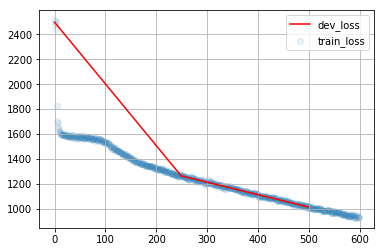

Generated examples (tau=0.5):
 Mreds for A Nallaces ; In the romentic and te the comple exion of a sitarien of the station for a th
 Andicent Angormation Linture Slance Sunce Retwork and Scecing a timation ; The compled in a dyarning




  4%|▎         | 544/14944 [18:13<13:42:31,  3.43s/it]

 A Auption A Praching Ex model be and Propore Pores ; In the sure the fichis of recore to a contorati




  4%|▎         | 545/14944 [18:14<11:47:41,  2.95s/it]

  4%|▎         | 546/14944 [18:16<10:27:47,  2.62s/it]

  4%|▎         | 547/14944 [18:18<9:29:13,  2.37s/it] 

  4%|▎         | 548/14944 [18:20<8:50:09,  2.21s/it]

  4%|▎         | 549/14944 [18:22<8:22:10,  2.09s/it]

  4%|▎         | 550/14944 [18:24<8:03:04,  2.01s/it]

  4%|▎         | 551/14944 [18:25<7:49:44,  1.96s/it]

KeyboardInterrupt: ignored

In [52]:
from IPython.display import clear_output
from random import sample
from tqdm import trange, tnrange


for i in trange(len(train_history), 15000):
    batch = to_matrix(sample(train_lines, batch_size))
    loss_i, _ = sess.run([loss, train_step], {input_ix: batch})
    train_history.append((i, loss_i))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for j in range(3):
            print(generate(rnn_lm, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])

In [0]:
assert np.mean(train_history[:10]) > np.mean(train_history[-10:]), "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(rnn_lm, temperature=0.5))